# Divisão e Visualização de Dados
Este notebook realiza a divisão dos dados em conjuntos de treino, validação e teste, além de fornecer ferramentas para visualização dos dados.

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
from sklearn.model_selection import train_test_split


# Caminhos
ROOT_DIR = "frames"  # Pasta com os frames
LABELS_FILE = "OSATS_clean.xlsx"  # Arquivo com os rótulos

# Proporções para divisão
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Transformações
mean = [0.4434, 0.4797, 0.5037]
std = [0.1893, 0.1636, 0.1239]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, labels_file, video_ids, transform=None):
        self.root_dir = root_dir
        self.labels = pd.read_excel(labels_file)
        self.video_ids = video_ids
        self.transform = transform
        self.data = []

        for video_id in self.video_ids:
            video_frames_dir = os.path.join(self.root_dir, video_id)
            if os.path.exists(video_frames_dir):
                for frame_file in os.listdir(video_frames_dir):
                    if frame_file.endswith(('.jpg', '.png', '.jpeg')):
                        frame_path = os.path.join(video_frames_dir, frame_file)
                        label = self.labels.loc[self.labels['VIDEO'] == video_id, 'GRS'].values[0]
                        self.data.append((frame_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_path, label = self.data[idx]
        image = Image.open(frame_path)
        if self.transform:
            image = self.transform(image)
        return image, label

def split_data_by_video(labels_file, train_ratio, val_ratio, test_ratio):
    # Carregar os rótulos
    labels_df = pd.read_excel(labels_file)
    
    # Inicializar listas para os conjuntos
    train_ids, val_ids, test_ids = [], [], []
    
    # Iterar sobre cada classe
    for label in labels_df['GRS'].unique():
        # Filtrar os IDs dos vídeos para a classe atual
        video_ids = labels_df[labels_df['GRS'] == label]['VIDEO'].tolist()
        
        # Verificar se há amostras suficientes para divisão
        if len(video_ids) < 3:  # Se houver menos de 3 vídeos, alocar todos para treino
            train_ids.extend(video_ids)
            continue
        
        # Dividir em treino e restante
        train, temp = train_test_split(video_ids, test_size=(1 - train_ratio), random_state=42)
        
        # Verificar se o restante é suficiente para validação e teste
        if len(temp) < 2:  # Se o restante for menor que 2, alocar tudo para validação
            val_ids.extend(temp)
            continue
        
        # Dividir o restante em validação e teste
        val, test = train_test_split(temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
        
        # Adicionar aos conjuntos finais
        train_ids.extend(train)
        val_ids.extend(val)
        test_ids.extend(test)
    
    return train_ids, val_ids, test_ids

def create_dataloaders(root_dir, labels_file, train_ids, val_ids, test_ids, transform, batch_size=32):
    train_dataset = VideoFrameDataset(root_dir, labels_file, train_ids, transform)
    val_dataset = VideoFrameDataset(root_dir, labels_file, val_ids, transform)
    test_dataset = VideoFrameDataset(root_dir, labels_file, test_ids, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Dividir os dados por vídeo
train_ids, val_ids, test_ids = split_data_by_video(LABELS_FILE, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Criar os DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(ROOT_DIR, LABELS_FILE, train_ids, val_ids, test_ids, transform)

# Exemplo: verificar tamanhos
print(f"Treino: {len(train_loader.dataset)} frames")
print(f"Validação: {len(val_loader.dataset)} frames")
print(f"Teste: {len(test_loader.dataset)} frames")

Treino: 27441 frames
Validação: 5467 frames
Teste: 7206 frames


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.8431372838258744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].


Visualizando dados de treino:


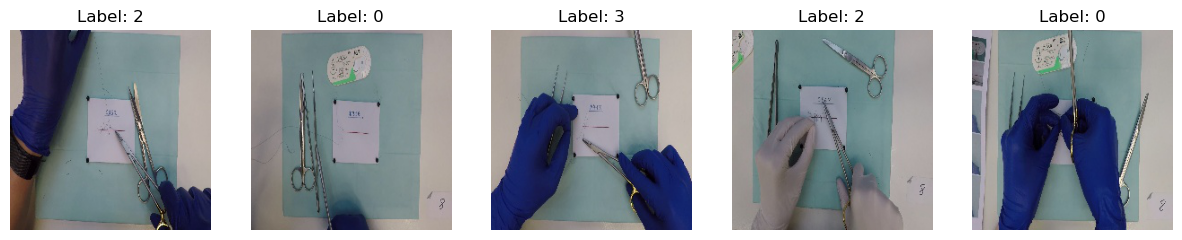

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.8980392411947251].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9764705834627152].


Visualizando dados de validação:


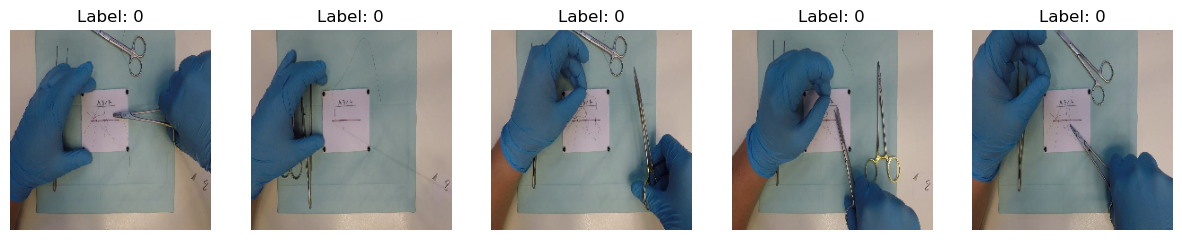

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.984313706946373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..1.000000043964386].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9999999611377716].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.222724913129696e-08..0.9882353269100189].


Visualizando dados de teste:


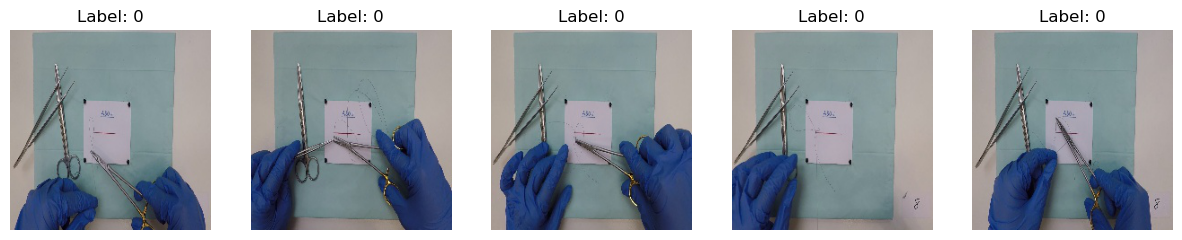

In [2]:
def visualize_data(loader, num_images=5):
    images, labels = next(iter(loader))
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.axis('off')
        plt.imshow(images[i].permute(1, 2, 0).numpy() * std + mean)
        plt.title(f"Label: {labels[i].item()}")
    plt.show()

# Visualizar dados de treino
print("Visualizando dados de treino:")
visualize_data(train_loader)

# Visualizar dados de validação
print("Visualizando dados de validação:")
visualize_data(val_loader)

# Visualizar dados de teste
print("Visualizando dados de teste:")
visualize_data(test_loader)

In [3]:
def visualize_dataset_split(train_loader, val_loader, test_loader):
    print(f"Quantidade de casos de Treino: {len(train_loader.dataset)}")
    print(f"Quantidade de casos de Validação: {len(val_loader.dataset)}")
    print(f"Quantidade de casos de Teste: {len(test_loader.dataset)}")

    for loader, name in zip([train_loader, val_loader, test_loader], ["Treino", "Validação", "Teste"]):
        x, y = next(iter(loader))
        print(f"\n{name}:")
        print(f"Shape tensor batch, input: {x.shape}, output: {y.shape}")
        print(f"Valor máximo no batch: {torch.max(x)} Valor mínimo no batch: {torch.min(x)}")
        x = x.detach().numpy()
        print(f"Valor máximo após conversão para numpy: {np.max(x)} Valor mínimo: {np.min(x)}")
        print(f"Rótulos no batch: {y}")

# Exemplo de uso
visualize_dataset_split(train_loader, val_loader, test_loader)

Quantidade de casos de Treino: 27441
Quantidade de casos de Validação: 5467
Quantidade de casos de Teste: 7206

Treino:
Shape tensor batch, input: torch.Size([32, 3, 224, 224]), output: torch.Size([32])
Valor máximo no batch: 4.005649566650391 Valor mínimo no batch: -4.065375804901123
Valor máximo após conversão para numpy: 4.005649566650391 Valor mínimo: -4.065375804901123
Rótulos no batch: tensor([2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 1, 0, 1, 2, 2, 1, 0, 3, 1, 2, 0, 0, 2,
        2, 0, 3, 0, 1, 1, 0, 0])

Validação:
Shape tensor batch, input: torch.Size([32, 3, 224, 224]), output: torch.Size([32])
Valor máximo no batch: 4.005649566650391 Valor mínimo no batch: -4.065375804901123
Valor máximo após conversão para numpy: 4.005649566650391 Valor mínimo: -4.065375804901123
Rótulos no batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Teste:
Shape tensor batch, input: torch.Size([32, 3, 224, 224]), output: torch.Size([32])
V

-----------------------------------Treino-----------------------------------
Total de casos em Treino: 27441
Classes: [0 1 2 3]
Frequências: [10058  5481 10073  1829]
Total: 27441


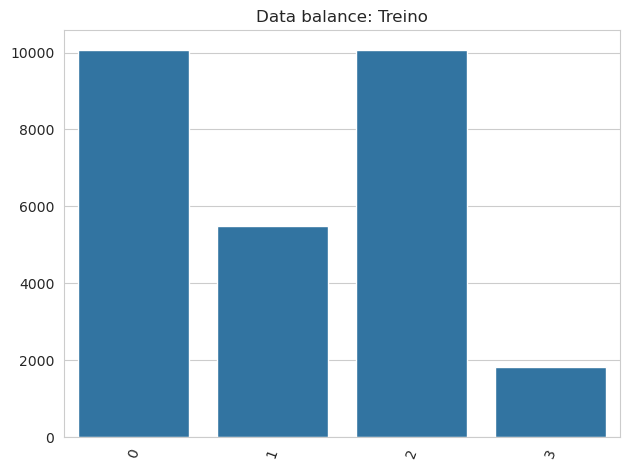

-----------------------------------Validação-----------------------------------
Total de casos em Validação: 5467
Classes: [0 1 2]
Frequências: [1819 1822 1826]
Total: 5467


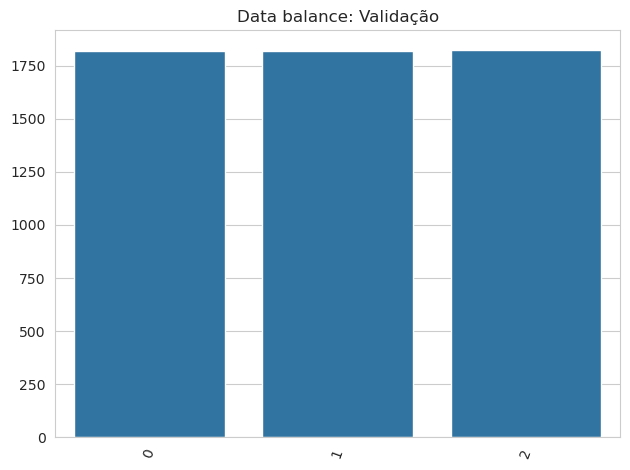

-----------------------------------Teste-----------------------------------
Total de casos em Teste: 7206
Classes: [0 1 2]
Frequências: [2751 1724 2731]
Total: 7206


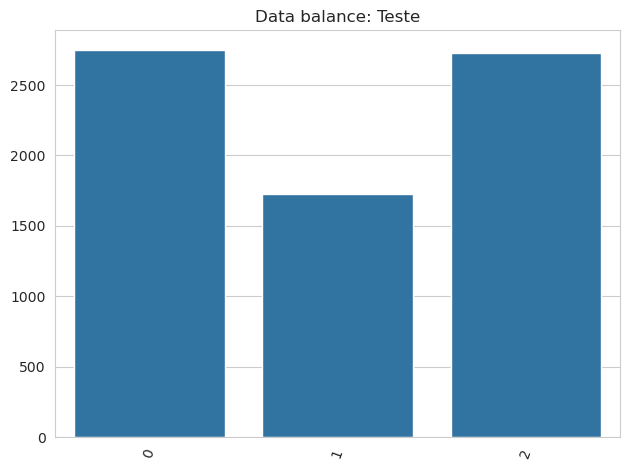

In [4]:
def visualize_data_balance(loader, titulo):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())

    sns.set_style('whitegrid')
    print(f"Total de casos em {titulo}: {len(all_labels)}")

    x, y = np.unique(all_labels, return_counts=True)

    print("Classes:", x)
    print("Frequências:", y)
    print("Total:", np.sum(y))

    grafico = sns.barplot(x=x, y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
print("-----------------------------------Treino-----------------------------------")
visualize_data_balance(train_loader, 'Treino')

print("-----------------------------------Validação-----------------------------------")
visualize_data_balance(val_loader, 'Validação')

print("-----------------------------------Teste-----------------------------------")
visualize_data_balance(test_loader, 'Teste')

-----------------------------------Treino-----------------------------------
Total de vídeos em Treino: 30


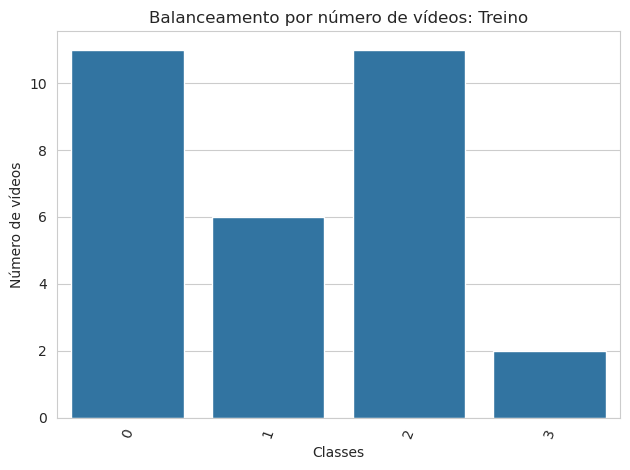

-----------------------------------Validação-----------------------------------
Total de vídeos em Validação: 6


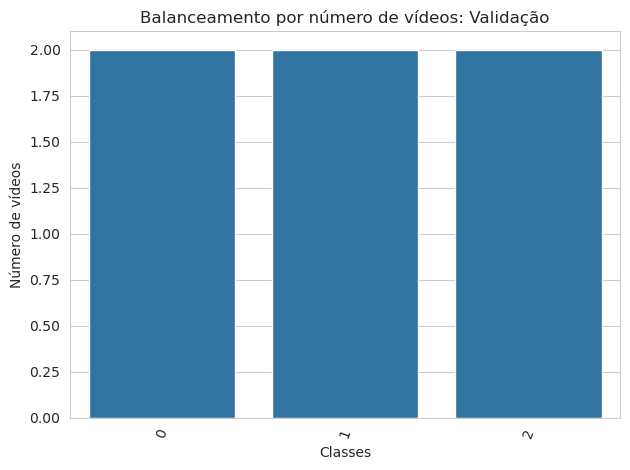

-----------------------------------Teste-----------------------------------
Total de vídeos em Teste: 8


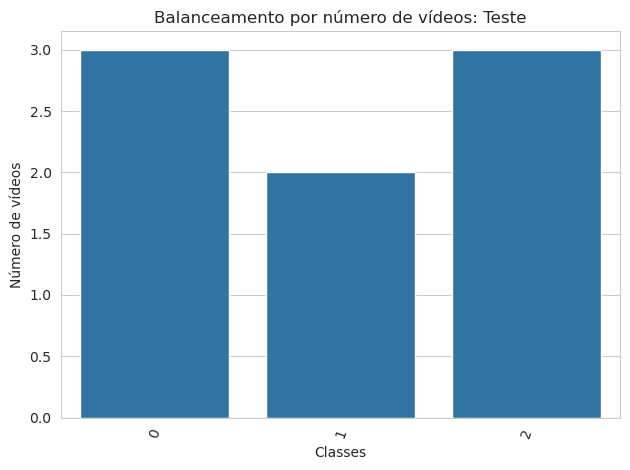

In [5]:
def visualize_video_balance(video_ids, labels_file, titulo):
    labels_df = pd.read_excel(labels_file)
    filtered_labels = labels_df[labels_df['VIDEO'].isin(video_ids)]
    class_counts = filtered_labels['GRS'].value_counts().sort_index()

    sns.set_style('whitegrid')
    print(f"Total de vídeos em {titulo}: {len(video_ids)}")

    grafico = sns.barplot(x=class_counts.index, y=class_counts.values)
    grafico.set_title(f'Balanceamento por número de vídeos: {titulo}')
    grafico.set_xlabel('Classes')
    grafico.set_ylabel('Número de vídeos')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
print("-----------------------------------Treino-----------------------------------")
visualize_video_balance(train_ids, LABELS_FILE, 'Treino')

print("-----------------------------------Validação-----------------------------------")
visualize_video_balance(val_ids, LABELS_FILE, 'Validação')

print("-----------------------------------Teste-----------------------------------")
visualize_video_balance(test_ids, LABELS_FILE, 'Teste')

## MODEL 

In [6]:
from torchinfo import summary

BATCH_SIZE = 32

cuda = torch.device("cuda")
torch.cuda.reset_peak_memory_stats()  
torch.cuda.empty_cache()

print(torch.cuda.memory_summary(device=0, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel2D(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel2D, self).__init__()
        
        # Sequential1: First Conv Layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduz (224, 224) -> (112, 112)
        )
        
        # Sequential2: Second Conv Layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduz (112, 112) -> (56, 56)
        )
        
        # Sequential3: Third Conv Layer
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduz (56, 56) -> (28, 28)
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Reduz (28, 28) -> (1, 1)
        
        # Fully Connected Layer
        self.fc = nn.Linear(in_features=64, out_features=num_classes)
    
    def forward(self, x):
        # Pass through the layers
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Global Average Pooling
        out = self.global_avg_pool(out)
        out = out.view(out.size(0), -1)  # Flatten (batch_size, 64, 1, 1) -> (batch_size, 64)
        
        # Fully Connected Layer
        out = self.fc(out)
        return out

# Exemplo de uso
num_classes = 4  # Número de classes (novice, intermediate, proficient, specialist)
model = CNNModel2D(num_classes=num_classes)
print(summary(model, input_size=(BATCH_SIZE, 3, 224, 224), verbose=2))



Layer (type:depth-idx)                   Output Shape              Param #
CNNModel2D                               [32, 4]                   --
├─Sequential: 1-1                        [32, 16, 112, 112]        --
│    └─0.weight                                                    ├─432
│    └─0.bias                                                      └─16
│    └─Conv2d: 2-1                       [32, 16, 224, 224]        448
│    │    └─weight                                                 ├─432
│    │    └─bias                                                   └─16
│    └─ReLU: 2-2                         [32, 16, 224, 224]        --
│    └─MaxPool2d: 2-3                    [32, 16, 112, 112]        --
├─Sequential: 1-2                        [32, 32, 56, 56]          --
│    └─0.weight                                                    ├─4,608
│    └─0.bias                                                      └─32
│    └─Conv2d: 2-4                       [32, 32, 112, 112]        

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, save_path):
    model.to(device)
    
    # Listas para armazenar métricas
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Loop de treinamento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Estatísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Treino - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validação - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    
    # Salvar o modelo treinado
    torch.save(model.state_dict(), save_path)
    print(f"Modelo salvo em: {save_path}")
    
    # Retornar métricas para plotagem
    return train_losses, train_accuracies, val_losses, val_accuracies

Epoch 1/2
Treino - Loss: 1.0448, Accuracy: 0.5046
Validação - Loss: 1.4230, Accuracy: 0.2650
Epoch 2/2
Treino - Loss: 0.6896, Accuracy: 0.7105
Validação - Loss: 1.5485, Accuracy: 0.3944
Modelo salvo em: Models/Task1/modelo_treinado_CNNModel2D_10_epochs.pth


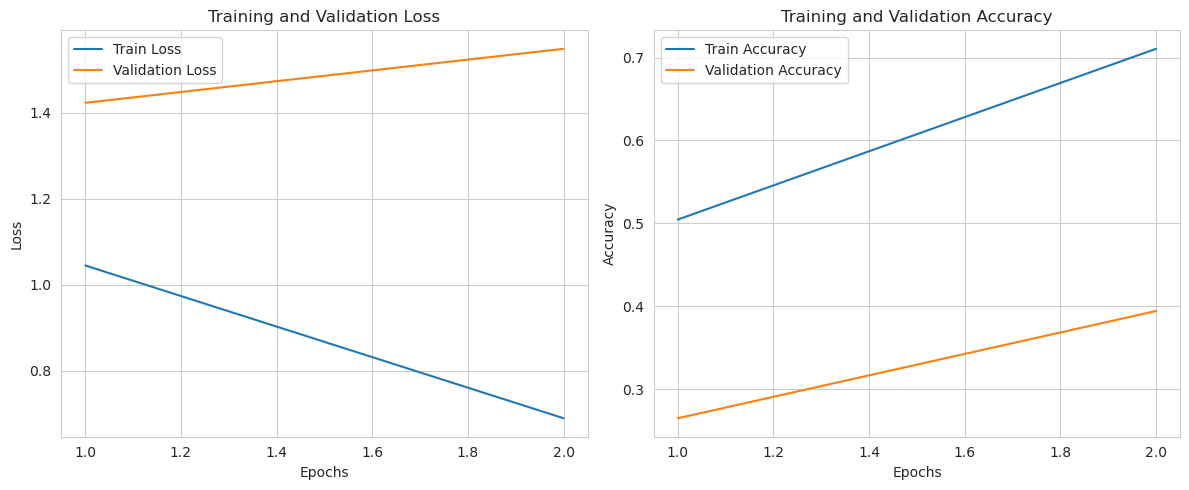

In [10]:
# Configurações
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel2D(num_classes=4)  # Substitua pelo modelo desejado
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 2
save_path = "Models/Task1/modelo_treinado_CNNModel2D_10_epochs.pth"



train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs, device, save_path
)

# Plotar os gráficos
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Avaliação do modelo
def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = correct / total
    print(f"Teste - Accuracy: {accuracy:.4f}")
    
    # Matriz de confusão
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    cm = confusion_matrix(all_labels, all_predictions)
    print("Relatório de Classificação:")
    print(classification_report(all_labels, all_predictions))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Matriz de Confusão")
    
    plt.show()

/tmp/ipykernel_100547/517128688.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Models/Task1/modelo_treinado_CNNModel2D_10_epochs.pth")

Teste - Accuracy: 0.3755
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57      2751
           1       0.17      0.10      0.12      1724
           2       0.72      0.31      0.43      2731
           3       0.00      0.00      0.00         0

    accuracy                           0.38      7206
   macro avg       0.35      0.26      0.28      7206
weighted avg       0.52      0.38      0.41      7206



/home/cid34senhas/miniconda3/envs/deepL2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/deepL2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/deepL2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

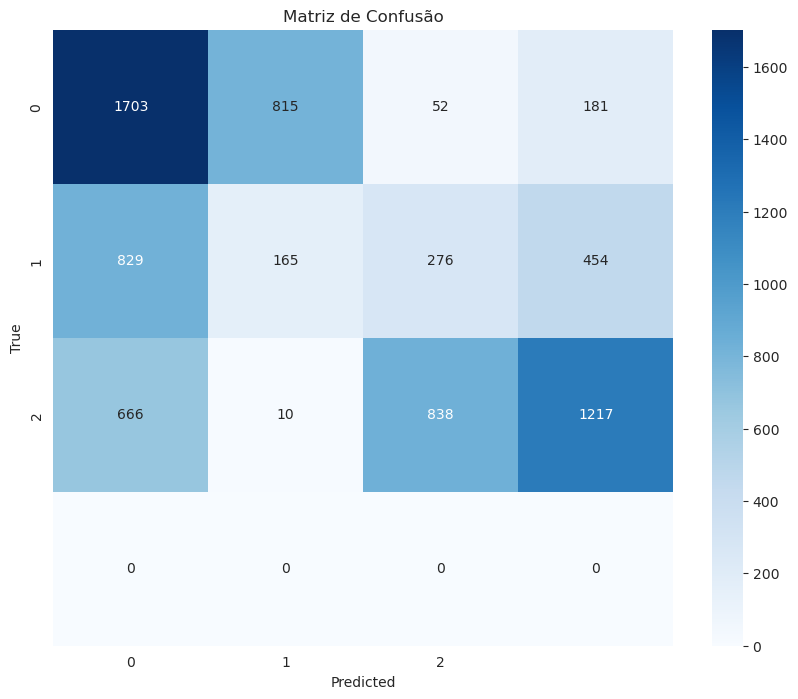

In [16]:
# Carregar o modelo treinado
model = CNNModel2D(num_classes=4)
model.load_state_dict(torch.load("Models/Task1/modelo_treinado_CNNModel2D_10_epochs.pth"))

# Avaliar o modelo
evaluate_model(model, test_loader, device)